## How convolutional neural networks see the world
### An exploration of convnet filters with Keras

First of all, let's start by defining the VGG16 model in Keras

In [13]:
from keras import applications

# build the VGG16 network
model = applications.VGG16(include_top=False, weights='imagenet')
model.summary()
# this is the placeholder for the input images
input_img = model.input

# get the symbolic ouputs of each 'key' layer(we gave them unique names).
layer_dict = dict([(layer.name, layer) for layer in model.layers[1:]])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0         
__________

Now let's define a loss function that will seek to maximize the activation of a specific filter(filter_index) in a specific layer(layer_name)

In [85]:
from keras import backend as K

layer_name = 'block5_conv3'
filter_index = 12 # can be any integer from 0 to 511, as there are 512 filters in that layer

# build a loss function that maximizes the activation
# of the nth filter of the layer considered
layer_output = layer_dict[layer_name].output
loss = K.mean(layer_output[:, :, :, filter_index])

# compute the gradient of the input picture wrt this loss
grads = K.gradients(loss, input_img)[0]

# normalization trick: we normalize the gradient
grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)

# this function returns the loss and grads given the input picture
iterate = K.function([input_img], [loss, grads])

Now we can use the Keras function we defined to do gradient ascent in the input space, with regard to our filter activation loss

In [69]:
import numpy as np

# we start from a gray image with some noise
img_width, img_height = 128, 128
input_img_data = np.random.random((1, img_width, img_height, 3))
input_img_data = (input_img_data - 0.5) * 20 + 128

# run gradient ascent for 20 steps
for i in range(20):
    loss_value, grads_value = iterate([input_img_data])
    input_img_data += grads_value * 1.
    print('loss %d: %f' % (i, loss_value))

loss 0: 0.067881
loss 1: 1.310091
loss 2: 1.774159
loss 3: 11.691547
loss 4: 14.804670
loss 5: 26.879017
loss 6: 38.673195
loss 7: 50.809311
loss 8: 62.848705
loss 9: 69.529755
loss 10: 80.242210
loss 11: 91.494263
loss 12: 102.407448
loss 13: 114.606689
loss 14: 120.434708
loss 15: 135.922562
loss 16: 140.734894
loss 17: 155.691589
loss 18: 162.292938
loss 19: 180.240295


We can then extract and display the generated input:

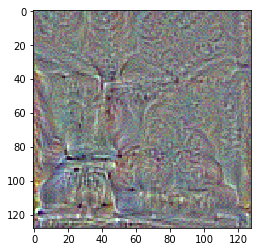

In [70]:
import matplotlib.pyplot as plt

# util function to convert a tensor into a valid image
def deprocess_image(x):
    # normalize tensor: center on0., ensure std is 0.1
    x -= x.mean()
    x /= (x.std() + 1e-5)
    x *= 0.1
    
    # clip to [0, 1]
    x += 0.5
    x = np.clip(x, 0, 1)
    
    # convert to RGB array
    x *=255
    x = np.clip(x, 0, 255).astype('uint8')
    return x

img = input_img_data[0]
img = deprocess_image(img)

plt.imshow(img)
plt.show()

### Finding an input that maximizes a specific class

In [98]:
from tqdm import tqdm

model = applications.VGG16(include_top=True, weights='imagenet')

In [105]:
input_img = model.input
output_index = 18

loss = K.mean(model.output[:, output_index])
grads = K.gradients(loss, input_img)[0]
grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)
iterate = K.function([input_img], [loss, grads])

img_width, img_height = 224, 224
input_img_data = np.random.random((1, img_width, img_height, 3))
input_img_data = (input_img_data - 0.5) * 20 + 128

for i in tqdm(range(100)):
    loss_value, grads_value = iterate([input_img_data])
    input_img_data += grads_value * 1.
print(loss_value)

100%|██████████| 100/100 [01:54<00:00,  1.12s/it]

0.998929


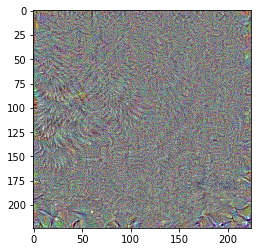

In [106]:
img = input_img_data[0]
img = deprocess_image(img)

plt.imshow(img)
plt.show()